In [1]:
import pandas as pd
from example.nuscenes.av_discretizer  import AVDiscretizer
from example.nuscenes.transition import TransitionRecorded
from nuscenes import NuScenes
import matplotlib.pyplot as plt
from pathlib import Path
import pgeon.policy_graph as PG
from example.nuscenes.environment import SelfDrivingEnvironment


In [2]:
# This is the path where you stored the copy of the nuScenes dataset.

#MINI
DATAROOT = Path('/home/saramontese/Desktop/MasterThesis/example/nuscenes/dataset/data/sets/nuscenes')
nuscenes = NuScenes('v1.0-mini', dataroot=DATAROOT)


#FULL
#DATAROOT = Path('/media/saramontese/Riccardo 500GB/NuScenesDataset/data/sets/nuscenes')
#nuscenes = NuScenes('v1.0-trainval', dataroot=DATAROOT)

Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.457 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.


The dataset contains the following columns for each state of the self-driving car:

- instance_token: A unique identifier for the vehicle instance.
- translation: The vehicle's position in 3D space (x, y, z coordinates).
- yaw: The orientation of the vehicle around the vertical axis (rotation angle).
- velocity: The vehicle's speed in a given direction.
- acceleration: The change in velocity over time.
- heading_change_rate: The rate of change of the vehicle's direction.
- timestamp: The time at which the state was recorded.
- scene_token: A unique identifier for the scenario or environment the vehicle is in

Load the CSV data into a DataFrame


In [3]:

dtype_dict = {
    'modality': 'category',  # for limited set of modalities, 'category' is efficient
    'scene_token': 'str',  
    'timestamp': 'str',  # To enable datetime operations
    'rotation': 'object',  # Quaternion (lists)
    'x': 'float64',
    'y': 'float64',
    'z': 'float64',
    'yaw': 'float64',  
    'velocity': 'float64',
    'acceleration': 'float64',
    'heading_change_rate': 'float64',
    'delta_local_x': 'float64',
    'delta_local_y': 'float64'
}
df = pd.read_csv(DATAROOT / 'dataset_from_ego.csv', dtype=dtype_dict, parse_dates=['timestamp'])

df.head()

,modality,scene_token,timestamp,rotation,x,y,z,yaw,velocity,acceleration,heading_change_rate,delta_local_x,delta_local_y
0,lidar,2fc3753772e241f2ab2cd16a784cc680,2018-08-30 19:25:09.301132,"[-0.1557237496690409, 0.011222825001502285, 0....",329.647494,660.196689,0.0,2.828707,5.108550,-0.034804,-0.045330,0.000000,0.000000
1,lidar,2fc3753772e241f2ab2cd16a784cc680,2018-08-30 19:25:09.801064,"[-0.16117694469754024, 0.009157178788916257, 0...",327.233834,661.025514,0.0,2.817706,5.104695,-0.007711,-0.022006,0.045648,2.551592
2,lidar,2fc3753772e241f2ab2cd16a784cc680,2018-08-30 19:25:10.200261,"[-0.16222999791894513, 0.010261981974878865, -...",325.362312,661.686833,0.0,2.815673,4.972301,-0.331650,-0.005091,0.031316,1.984681
3,lidar,2fc3753772e241f2ab2cd16a784cc680,2018-08-30 19:25:10.651414,"[-0.16605361559690043, 0.007585584174464603, -...",323.362925,662.405363,0.0,2.807968,4.709219,-0.583132,-0.017080,0.040541,2.124192
4,lidar,2fc3753772e241f2ab2cd16a784cc680,2018-08-30 19:25:11.149672,"[-0.1790782272855317, 0.009448521999393368, -0...",321.358449,663.164911,0.0,2.781689,4.302103,-0.817080,-0.052741,0.061262,2.142681


## Trajectory of AV in a Scene

Let's do an example of computing trajectory of a vehicle in a scene. We then check if the rendering of the scene match the computed trajectory.

In [4]:
# initialize discretizer
av_discretizer = AVDiscretizer()


List of scenes

In [5]:
df['scene_token'].unique()

array(['2fc3753772e241f2ab2cd16a784cc680',
       '325cef682f064c55a255f2625c533b75',
       '6f83169d067343658251f72e1dd17dbc',
       'bebf5f5b2a674631ab5c88fd1aa9e87a',
       'c5224b9b454b4ded9b5d2d2634bbda8a',
       'cc8c0bf57f984915a77078b10eb33198',
       'd25718445d89453381c659b9c8734939',
       'de7d80a1f5fb4c3e82ce8a4f213b450a',
       'e233467e827140efa4b42d2b4c435855',
       'fcbccedd61424f1b85dcbf8f897f9754'], dtype=object)

Select a scene and test the  algorithm


In [6]:
scene_test = 'bebf5f5b2a674631ab5c88fd1aa9e87a'
example_scene_df = df[df['scene_token']==scene_test]
example_scene_df

,modality,scene_token,timestamp,rotation,x,y,z,yaw,velocity,acceleration,heading_change_rate,delta_local_x,delta_local_y
117,lidar,bebf5f5b2a674631ab5c88fd1aa9e87a,2018-08-27 15:51:33.200183,"[0.9997929727538482, -0.016152305750894613, -0...",1780.747230,866.457240,0.0,0.024381,8.185916,0.986673,0.000055,0.000000,0.000000
118,lidar,bebf5f5b2a674631ab5c88fd1aa9e87a,2018-08-27 15:51:33.650312,"[0.9998022092861187, -0.015130044333050515, -0...",1784.563552,866.529807,0.0,0.025816,8.479817,0.652925,0.003189,0.020490,3.816957
119,lidar,bebf5f5b2a674631ab5c88fd1aa9e87a,2018-08-27 15:51:34.150195,"[-0.9997849035463522, 0.015034734236142825, -0...",1788.868911,866.606685,0.0,0.028432,8.614106,0.268641,0.005232,0.034284,4.305909
120,lidar,bebf5f5b2a674631ab5c88fd1aa9e87a,2018-08-27 15:51:34.550004,"[-0.9997533463143026, 0.015583503535431465, -0...",1792.295493,866.679112,0.0,0.031605,8.572463,-0.104158,0.007936,0.025012,3.427256
121,lidar,bebf5f5b2a674631ab5c88fd1aa9e87a,2018-08-27 15:51:34.949783,"[-0.999757477107573, 0.014142393272879727, 0.0...",1795.704829,866.764818,0.0,0.033744,8.530746,-0.104349,0.005351,0.022069,3.410342
122,lidar,bebf5f5b2a674631ab5c88fd1aa9e87a,2018-08-27 15:51:35.449675,"[-0.9997730328168501, 0.010707596019344248, 0....",1800.040729,866.864654,0.0,0.036661,8.675973,0.290517,0.005835,0.046502,4.336800
123,lidar,bebf5f5b2a674631ab5c88fd1aa9e87a,2018-08-27 15:51:35.949554,"[-0.9997284293038398, 0.0113370846014813, 0.00...",1804.249912,866.978742,0.0,0.040696,8.423495,-0.505080,0.008074,0.040266,4.210536
124,lidar,bebf5f5b2a674631ab5c88fd1aa9e87a,2018-08-27 15:51:36.399680,"[-0.9997073223214882, 0.011178170352553354, 0....",1807.990843,867.097895,0.0,0.042913,8.315070,-0.240877,0.004924,0.033146,3.742682
125,lidar,bebf5f5b2a674631ab5c88fd1aa9e87a,2018-08-27 15:51:36.900138,"[-0.9996069825359233, 0.01475966089454273, 0.0...",1812.242381,867.254283,0.0,0.047669,8.501038,0.371596,0.009504,0.026145,4.254332
126,lidar,bebf5f5b2a674631ab5c88fd1aa9e87a,2018-08-27 15:51:37.400558,"[-0.9995864948616396, 0.014064254863061424, -0...",1816.572582,867.442139,0.0,0.049560,8.661273,0.320202,0.003779,0.018696,4.334234


Compute the trajectoy of the scene

In [7]:
recorder = TransitionRecorded()
trajectory = av_discretizer.compute_trajectory(example_scene_df)
recorder.process_and_save_transitions(trajectory, av_discretizer.unique_states)

State 0: [0.0, 0.0, 8.185916400546434, 0.0243809127521553, 5.5280221261210464e-05, 0.9866729026571752, Timestamp('2018-08-27 15:51:33.200183')]
Discretized state: 0 [(445, 216)]&[<Velocity.MEDIUM: 3>]&[<Rotation.FORWARD: 3>]
Action: {<Action.GAS: 4>, <Action.STRAIGHT: 11>}

State 1: [0.0204902001644104, 3.816956541049537, 8.479816982325772, 0.0258161513712863, 0.0031885051154913, 0.6529252320542296, Timestamp('2018-08-27 15:51:33.650312')]
Discretized state: 1 [(446, 216)]&[<Velocity.MEDIUM: 3>]&[<Rotation.FORWARD: 3>]
Action: {<Action.STRAIGHT: 11>}

State 2: [0.03428355445337, 4.305908571346248, 8.614105804071992, 0.0284317504580207, 0.0052324225603477, 0.2686405053706952, Timestamp('2018-08-27 15:51:34.150195')]
Discretized state: 2 [(447, 216)]&[<Velocity.MEDIUM: 3>]&[<Rotation.FORWARD: 3>]
Action: {<Action.STRAIGHT: 11>}

State 3: [0.0250124999878748, 3.4272564124163893, 8.572462558896854, 0.0316045914072956, 0.0079358917615035, -0.1041578483104122, Timestamp('2018-08-27 15:51:34.

Plot trend of state in time for each instance of a scene.

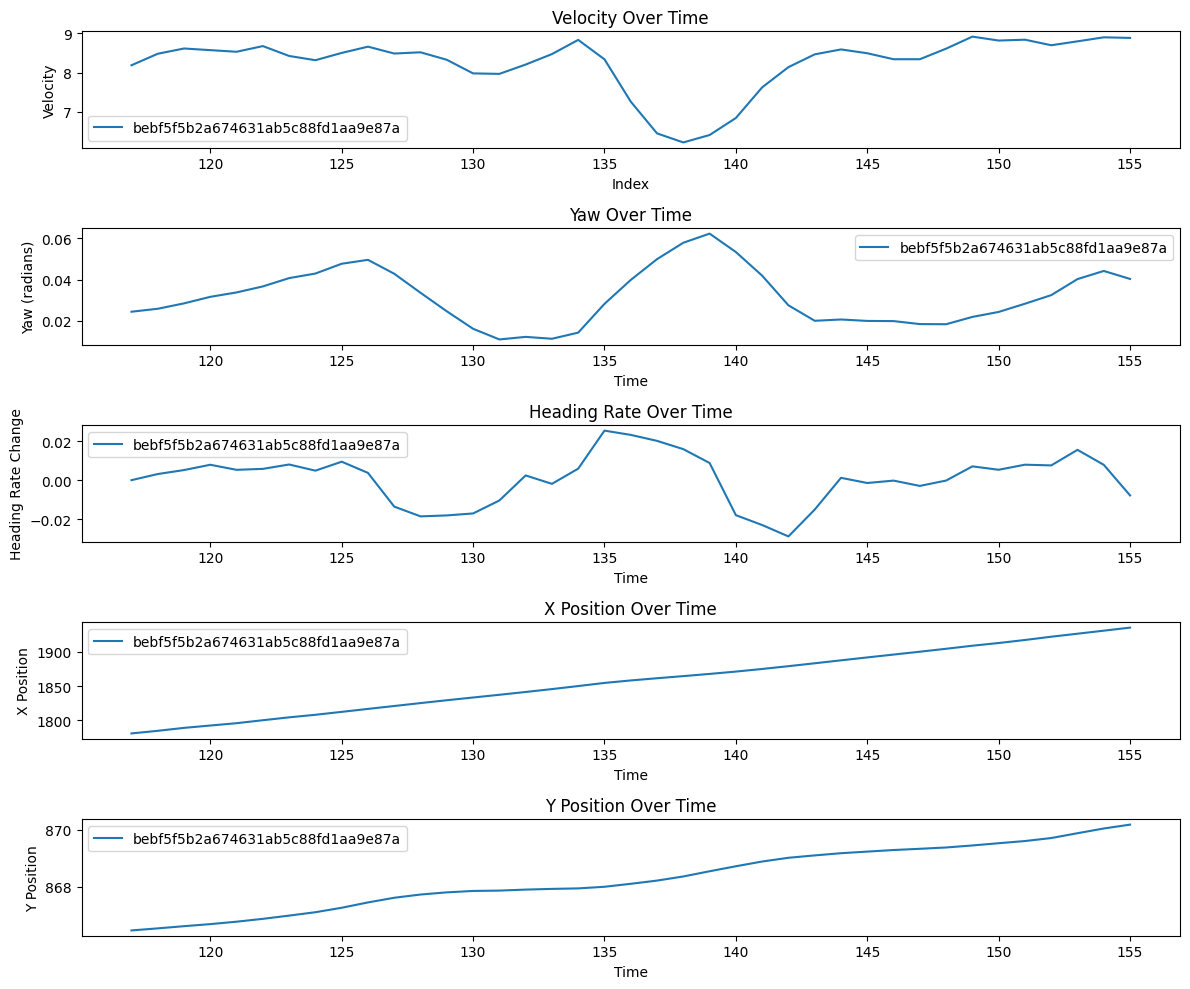

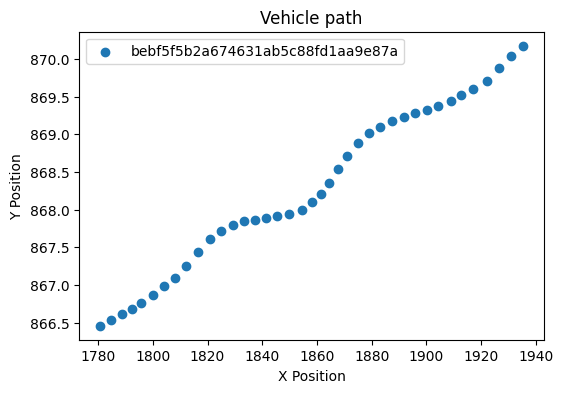

In [8]:
plt.figure(figsize=(12, 10))

plt.subplot(5, 1, 1)
for scene_token, group in example_scene_df.groupby('scene_token'):
    plt.plot(group.index, group['velocity'], label=scene_token)
plt.title('Velocity Over Time')
plt.xlabel('Index')
plt.ylabel('Velocity')
plt.legend()

plt.subplot(5, 1, 2)
for scene_token, group in example_scene_df.groupby('scene_token'):
    plt.plot(group.index, group['yaw'], label=scene_token)
plt.title('Yaw Over Time')
plt.xlabel('Time')
plt.ylabel('Yaw (radians)')
plt.legend()

plt.subplot(5, 1, 3)
for scene_token, group in example_scene_df.groupby('scene_token'):
    plt.plot(group.index, group['heading_change_rate'], label=scene_token)
plt.title('Heading Rate Over Time')
plt.xlabel('Time')
plt.ylabel('Heading Rate Change')
plt.legend()

plt.subplot(5, 1, 4)
for scene_token, group in example_scene_df.groupby('scene_token'):
    plt.plot(group.index, group['x'], label=scene_token)
plt.title('X Position Over Time')
plt.xlabel('Time')
plt.ylabel('X Position')
plt.legend()

plt.subplot(5, 1, 5)  # Moved inside the same plt.figure block
for scene_token, group in example_scene_df.groupby('scene_token'):
    plt.plot(group.index, group['y'], label=scene_token)
plt.title('Y Position Over Time')
plt.xlabel('Time')
plt.ylabel('Y Position')
plt.legend()

plt.tight_layout()
plt.show()


# Plot x vs y positions for each instance
plt.figure(figsize=(6, 4))
for scene_token, group in example_scene_df.groupby('scene_token'):
    plt.scatter(group['x'], group['y'], label=scene_token)
plt.title('Vehicle path')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.legend()
plt.show()

To render the scene (video):

In [9]:
#nuscenes.render_scene(scene_test)



## All scenes trajectory information


Now, apply the above to all scenes in the dataset.

In [10]:
av_discretizer = AVDiscretizer()

trajectory = av_discretizer.compute_trajectory(df)

State 0: [0.0, 0.0, 5.108549775006556, 2.8287073423413176, -0.0453298240761698, -0.0348037318593867, Timestamp('2018-08-30 19:25:09.301132')]
Discretized state: 0 [(82, 165)]&[<Velocity.LOW: 2>]&[<Rotation.RIGHT: 5>]
Action: {<Action.STRAIGHT: 11>}

State 1: [0.0456478454936385, 2.5515920468546924, 5.10469490440442, 2.817705897134056, -0.0220058832146411, -0.007710789871694, Timestamp('2018-08-30 19:25:09.801064')]
Discretized state: 1 [(81, 165)]&[<Velocity.LOW: 2>]&[<Rotation.RIGHT: 5>]
Action: {<Action.STRAIGHT: 11>}

State 2: [0.0313156638906143, 1.9846806565211763, 4.972301147669266, 2.815673479305952, -0.0050912652853189, -0.3316501795733787, Timestamp('2018-08-30 19:25:10.200261')]
Discretized state: 2 [(81, 165)]&[<Velocity.LOW: 2>]&[<Rotation.RIGHT: 5>]
Action: {<Action.BRAKE: 5>, <Action.STRAIGHT: 11>}

State 3: [0.0405408994690575, 2.1241916563087795, 4.709219465049271, 2.807967705113446, -0.0170801794347065, -0.5831318479983395, Timestamp('2018-08-30 19:25:10.651414')]
Disc

In [11]:
transition = TransitionRecorded()

path_pg_data = Path('/home/saramontese/Desktop/MasterThesis/example/nuscenes/dataset/data/sets/nuscenes')
transition.process_and_save_transitions(trajectory, av_discretizer.unique_states, path=str(path_pg_data))

# Policy Graph Generation

In [18]:
env = SelfDrivingEnvironment()


In [19]:
av_discretizer = AVDiscretizer()

pg = PG.PolicyGraph.from_nodes_and_edges(str(path_pg_data / 'nuscenes_nodes.csv'), str(path_pg_data / 'nuscenes_edges.csv'), env, av_discretizer  )

In [20]:
print(f'Number of nodes: {len(pg.nodes)}')
print(f'Number of edges: {len(pg.edges)}')

Number of nodes: 235
Number of edges: 284


In [15]:
arbitrary_state = list(pg.nodes)[0]

print(arbitrary_state)
print(f'  Times visited: {pg.nodes[arbitrary_state]["frequency"]}')
print(f'  p(s):          {pg.nodes[arbitrary_state]["probability"]:.3f}')

((82, 165), <Velocity.LOW: 2>, <Rotation.RIGHT: 5>)
  Times visited: 1
  p(s):          0.003


In [16]:
arbitrary_edge = list(pg.edges)[0]

print(f'From:    {arbitrary_edge[0]}')
print(f'Action:  {arbitrary_edge[2]}')
print(f'To:      {arbitrary_edge[1]}')
print(f'  Times visited:      {pg[arbitrary_edge[0]][arbitrary_edge[1]][arbitrary_edge[2]]["frequency"]}')
print(f'  p(s_to,a | s_from): {pg[arbitrary_edge[0]][arbitrary_edge[1]][arbitrary_edge[2]]["probability"]:.3f}')

From:    ((82, 165), <Velocity.LOW: 2>, <Rotation.RIGHT: 5>)
Action:  5
To:      ((81, 165), <Velocity.LOW: 2>, <Rotation.RIGHT: 5>)
  Times visited:      1
  p(s_to,a | s_from): 1.000


In [17]:
len(pg._trajectories_of_last_fit)


0